In [2]:
import numpy as np
import argparse
import csv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.random.seed(42)
import math
import random

In [3]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
NUM_ITER = 100000
MAX_POWER = 9
SUBSET = 100
N_FOLDS = 10
ERROR = "mse"
REGULARIZATION_LAMBDA = 1e-8

In [4]:
def readData(filename):
    dataset = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readData('gaussian.csv')

In [5]:
dataset = dataset[:SUBSET]

In [6]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [7]:
# highest power is m here
def makeDesignMat(x,m):
    return np.vander(x,m+1,increasing=True)

In [8]:
def chunkarr(arr,n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [9]:
def plot_error(train_err_list,test_err_list):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g")
    plt.plot(xa,test_err_list,color="r")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.show()

In [10]:
def descent(trainX,y,testX,testY,lambd = 0.0, err_function = "mse" ):
    #m = len(trainX)
    w = np.random.rand(MAX_POWER+1)
    y = np.array(y)
    X = makeDesignMat(trainX,MAX_POWER)
    Xchunks = chunkarr(X,BATCH_SIZE)
    ychunks = chunkarr(y,BATCH_SIZE)
    train_err_list = []
    test_err_list = []
    lr = LEARNING_RATE
    flag = False
    for j in tqdm(range(NUM_ITER)):
        preverr = testError(trainX,y,w,MAX_POWER)
        #print(preverr)
        for chunk in range(len(Xchunks)):
            Xcon = Xchunks[chunk]
            ycon = ychunks[chunk]
            pred = np.dot(Xcon,w)
            test_err_list.append(testError(testX,testY,w,MAX_POWER))
            if err_function == "mse":
                err = 0.5 * (np.sum(np.square(pred-ycon)) + lambd*np.sum(np.square(w)))/len(ycon)
                grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)/len(ycon)
            if err_function == "mae":
                err = np.sum(np.abs(pred-ycon))
                parity = np.sign(pred - ycon)
                parity = parity.reshape((len(ycon),1))
                grad = np.sum(np.multiply(parity,Xcon).T,axis=1)/len(ycon)
            if err_function == "huber":
                e = 0.1
                temp = pred-ycon
                err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e)))
                err += lambd*np.sum(np.square(w))
                err /= len(ycon)
                grad = np.zeros((MAX_POWER+1,))
                for i in range(len(ycon)):
                    if np.abs(temp[i]<=e):
                        grad += temp[i]*Xcon[i,:]
                    else:
                        grad += e*np.sign(temp[i])*Xcon[i,:]
                grad+=2*lambd*w
                w = np.squeeze(w)
                grad /=len(ycon)
                grad = np.squeeze(grad)
            w = w - lr * grad
            train_err_list.append(err)
        newerr = testError(trainX,y,w,MAX_POWER)
        if(j%1000==0):
            print(newerr)
        if(newerr<0.03):
            continue
        lr = LEARNING_RATE * math.exp(-0.0015*j/NUM_ITER)
    plot_error(train_err_list,test_err_list)
    return w

In [11]:
def plot_reg(trainX,trainY,testX,testY,w):
    def aux(X_line,w):
        temp = 0
        for i in range(len(w)):
            temp += np.power(X_line,i) * w[i]
        return temp
    jointX = np.concatenate((trainX,testX))
    plt.clf()
    plt.scatter(trainX,trainY,color='b',marker ='o',s=15)
    plt.scatter(testX,testY,color="m",marker='o',s=30)
    x_line = np.linspace(min(jointX),max(jointX),100)
    y_pred = aux(x_line,w)
    plt.plot(x_line,y_pred, color='g')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()
    return plt

In [12]:
def testError(testX, testY,w,MAX_POWER):
    testX = makeDesignMat(testX,MAX_POWER)
    pred = np.dot(testX,w)
    if ERROR == "mse":
        err = 0.5 * (np.sum(np.square(pred-testY)))/len(testY)
    elif ERROR == "mae":
        err = np.sum(np.abs(pred-testY)) / len(testY)
    elif ERROR == "huber":
        e = 0.1
        temp = pred-testY
        err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e))) / len(testY)
    return err

In [13]:
def evaluate(dataset):
    folds = cross_validation_split(dataset)
    err_list = []
    for fold in folds:
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        w = descent(trainX,trainY,testX,testY,REGULARIZATION_LAMBDA,ERROR)
        print(w)
        plot_reg(trainX,trainY,testX,testY,w)
        err = testError(testX,testY,w,MAX_POWER)
        err_list.append(err)
    avg_error = np.mean(err_list)
    print(err_list)
    return avg_error

279.8040711411376
0.7037194976889781
0.24621464570324514
0.14126418753228456
0.09932464264936412
0.07648223732994065
0.062283159473712
0.05288483851025881
0.04638545468318873
0.04170833349890012
0.038211779516020915
0.03550361121326935
0.033339143702285634
0.03156219515864379
0.0300704068935159
0.02879486672823219
0.027687239867655408
0.02671296757056747
0.02584648621995388
0.0250683850005207
0.024363596439408185
0.023720211410834344
0.02312868094656416
0.02258126221654176
0.02207162224654429
0.021594546280528096
0.021145717604174656
0.0207215476471884
0.020319042506124155
0.01993569656957805
0.019569406795760694
0.01921840304556275
0.01888119110240951
0.018556505847069707
0.018243272642416937
0.01794057540639943
0.01764763016491036
0.017363763113873967
0.017088392403689607
0.016821013003763728
0.016561184120117048
0.016308518731929292
0.016062674888308127
0.015823348468241658
0.015590267157345454
0.015363185436776908
0.015141880414223539
0.014926148355471939
0.01471580179881126
0.0145

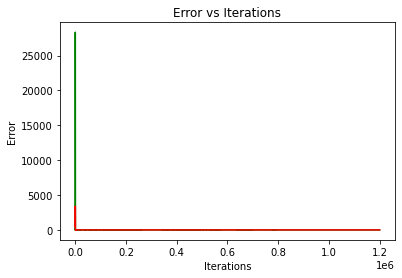

[ 4.00748011 -0.09375706 -0.35511677 -0.09461031  0.09162904  0.47993126
  0.87066166 -0.42416228 -0.54506762  0.24141872]


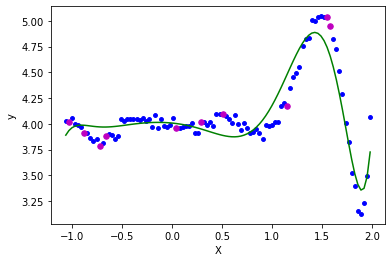

230.99416178103044
0.7094494525750611
0.3248225884249282
0.19787808093139791
0.13496216336999245
0.09883974692648181
0.0769275822940892
0.06315240400123258
0.054171762803660074
0.04807373292206134
0.04374836208779526
0.040543422992136535
0.03806982683836716
0.03609086127024404
0.03445894350962125
0.033079348239788794
0.0318892658937556
0.03084559670496367
0.029917736854291985
0.029083167710599014
0.02832509612177167
0.027630517056360097
0.026989207460296545
0.026393014333000685
0.02583536127393057
0.02531089645539747
0.02481523424166323
0.024344760645270636
0.023896483664419287
0.023467916128910957
0.023056982736084863
0.022661945508041882
0.02228134354710201
0.02191394405942659
0.021558702364891526
0.02121472913896174
0.02088126351514366
0.020557650961477172
0.020243325061200617
0.019937792495578668
0.019640620658820516
0.01935142743998366
0.019069872791017867
0.01879565176825155
0.0185284887900229
0.018268132898428185
0.018014353850232753
0.01776693889247548
0.01752569010337631
0.017

KeyboardInterrupt: 

In [368]:
evaluate(dataset)

In [14]:
def evaluate_moorepenrose(dataset,MAX_POWER):
    folds = cross_validation_split(dataset)
    err_list = []
    best_testerr = 99999999
    corr_trainerr = 9999999
    bestw = []
    for j,fold in enumerate(folds):
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        X = makeDesignMat(trainX,MAX_POWER)
        #w = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),np.dot(X.transpose(),trainY))
        w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
        plt = plot_reg(trainX,trainY,testX,testY,w)
        plt.title(f"Moore Penrose with m={MAX_POWER}")
#         if j==0:
#             plt.savefig(f"Moore Penrose with m={MAX_POWER}.png",dpi=1200)
        trainerr = testError(trainX,trainY,w,MAX_POWER)
        testerr = testError(testX,testY,w,MAX_POWER)
        if testerr<best_testerr and trainerr<testerr:
            best_testerr = testerr
            corr_trainerr = trainerr
            bestw = w
        #err_list.append([trainerr,testerr])
    #err_list = np.array(err_list)
    #avg_trainerror = np.mean(err_list[:,0])
    #avg_testerror = np.mean(err_list[:,1])
    #print(w)
    #print(err_list)
    return bestw,best_testerr,corr_trainerr

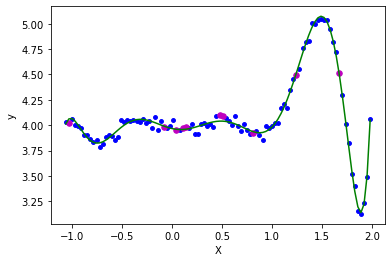

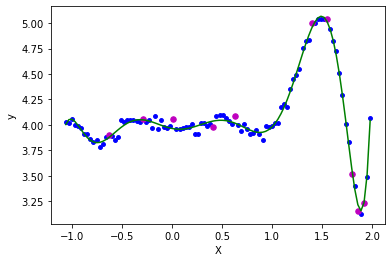

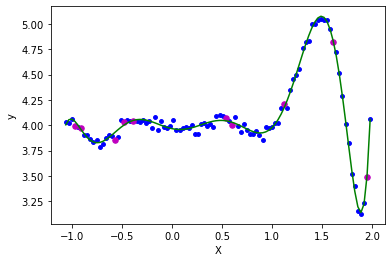

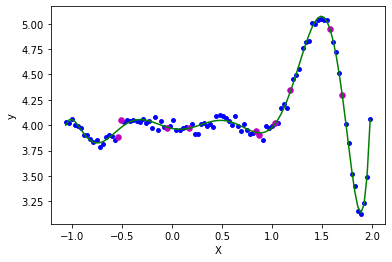

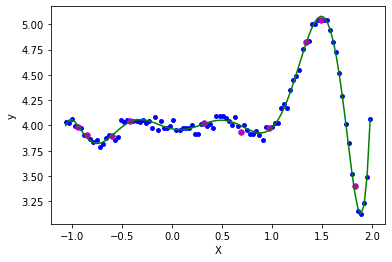

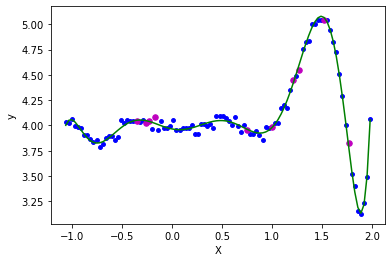

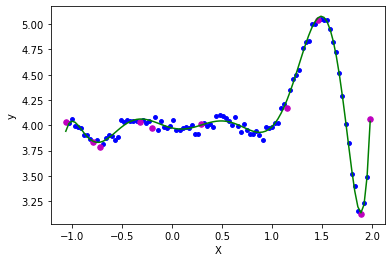

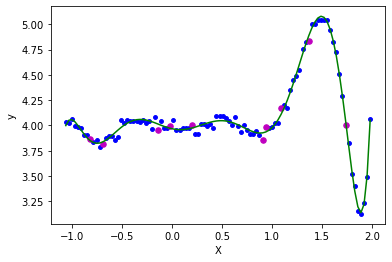

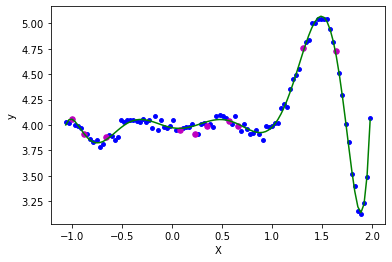

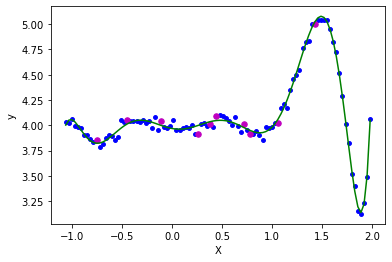

(array([ 3.97343651, -0.18030456,  1.11306556,  1.46176137, -5.39573483,
        -1.72356361,  7.30327611, -0.55871974, -2.97623535,  0.96159447]),
 0.0007750156304936203,
 0.0006701529691197667)

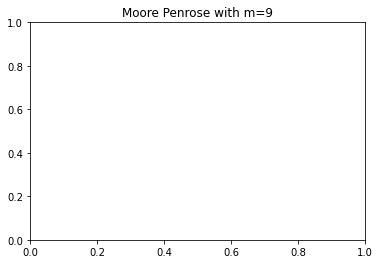

In [15]:
evaluate_moorepenrose(dataset,9)

In [16]:
def plotData(dataset):
    dataset = np.array(dataset)
    X = dataset[:,0]
    y = dataset[:,1]
    plt.scatter(X,y,color="b",marker='o',s=20)
    plt.ylabel('t')
    plt.xlabel('x')
    plt.title(f'Gaussian Noise Dataset n={SUBSET} points')
    plt.show
    #plt.savefig(f'Gaussian Noise Dataset_{SUBSET}.png',dpi=1200)

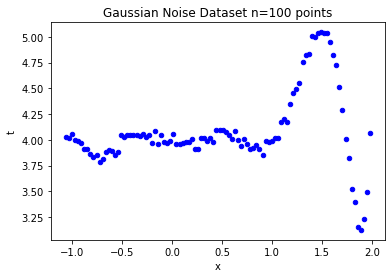

In [17]:
plotData(dataset)

In [240]:
def moorePenroseAnalysis(dataset):
    testerrlist = []
    trainerrlist = []
    for MAX_POWER in range(3,13):
        w,testerr,trainerr = evaluate_moorepenrose2(dataset,MAX_POWER)
        testerrlist.append(testerr)
        trainerrlist.append(trainerr)
    xa = np.arange(3,13)
    plt.clf()
    plt.plot(xa,trainerrlist,color='r',label="Training error")
    plt.plot(xa,testerrlist,color='b',label="Testing error")
    plt.legend()
    plt.savefig('Moore Penrose(Error vs m).png',dpi=1200)
    plt.show()

1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12


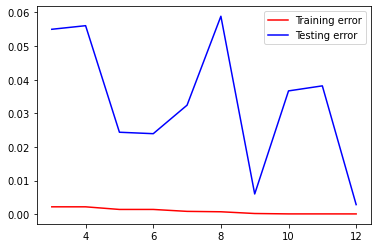

In [241]:
moorePenroseAnalysis(dataset)

In [209]:
def moorePenroseRegAnalysis(dataset):
    testerrlist = []
    trainerrlist = []
    global REGULARIZATION_LAMBDA
    for reg in [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]:
        REGULARIZATION_LAMBDA = reg
        w,testerr,trainerr = evaluate_moorepenrose2(dataset,9)
        testerrlist.append(testerr)
        trainerrlist.append(trainerr)
    xa = np.arange(-12,0)
    plt.clf()
    plt.plot(xa,trainerrlist,color='r',label="Training error")
    plt.plot(xa,testerrlist,color='b',label="Testing error")
    plt.legend()
    plt.xlabel("log(lambda)")
    plt.ylabel("Error")
    plt.title("Error vs Lambda")
    plt.savefig('Error vs Lambda.png',dpi=1200)
    plt.show()

1e-12
1e-11
1e-10
1e-09
1e-08
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1


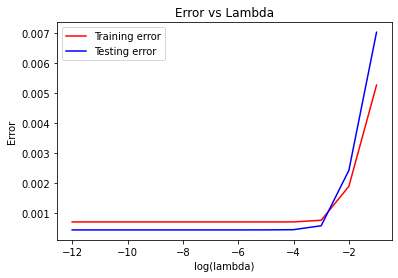

In [226]:
moorePenroseRegAnalysis(dataset)

In [18]:
def pseudoInv(X,t):
    pseudoInverse=np.linalg.pinv(X)
    weights=pseudoInverse @ t
    return(weights)

In [19]:
ds = np.array(dataset)
finw = pseudoInv(makeDesignMat(ds[:,0],9),ds[:,1])

In [230]:
def evaluate_moorepenrose2(dataset,MAX_POWER):
    dataset = np.array(dataset)
    trainDS = dataset[:18]
    testDS = dataset[18:]
    trainX = trainDS[:,0]
    trainY = trainDS[:,1]
    testX = testDS[:,0]
    testY = testDS[:,1]
    X = makeDesignMat(trainX,MAX_POWER)
    print(REGULARIZATION_LAMBDA)
    w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
    plt = plot_reg(trainX,trainY,testX,testY,w)
    plt.title(f"Moore Penrose with m={MAX_POWER}")
#         if j==0:
#             plt.savefig(f"Moore Penrose with m={MAX_POWER}.png",dpi=1200)
    trainerr = testError(trainX,trainY,w,MAX_POWER)
    testerr = testError(testX,testY,w,MAX_POWER)
    return w,testerr,trainerr

In [33]:
XX = makeDesignMat(ds[:,0],9)
pred = np.dot(XX,finw)
beta = len(ds[:,1])/(np.sum(np.square(pred-ds[:,1])))
1/beta

0.0013441315056887191

Mean of noise is: 1.0627942970131698e-13
Standard deviation of noise is: 0.036662399071647214
-0.07942198069926354 0.08833266771018389


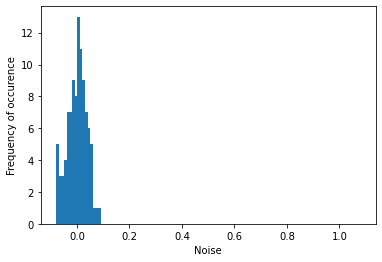

In [35]:
def getNoisePlot(trainX,trainY,w):
    trainX = makeDesignMat(trainX,MAX_POWER)
    preds = np.dot(trainX,w)
    noise = trainY-preds
    print(f"Mean of noise is: {np.mean(noise)}")
    print(f"Standard deviation of noise is: {np.std(noise)}")
    print(min(noise),max(noise))
    plt.clf()
    plt.hist(noise, bins=np.arange(noise.min(),noise.max()+1,0.01))
    plt.xlabel("Noise")
    plt.ylabel("Frequency of occurence")
getNoisePlot(ds[:,0],ds[:,1],finw)